In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [4]:
!mkdir ~/.kaggle/
from google.colab import drive
drive.mount('/content/drive')

! cp "/content/drive/MyDrive/kaggle API/kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!python -m pip install -qq kaggle
!kaggle datasets download -d joebeachcapital/hotel-reviews ## change data name
!unzip -qq "hotel-reviews"                                 ## change data name

Mounted at /content/drive
 99% 712M/717M [00:06<00:00, 137MB/s]
100% 717M/717M [00:06<00:00, 114MB/s]


## **Dataset**
https://www.kaggle.com/datasets/joebeachcapital/hotel-reviews


In [5]:
offr = pd.read_csv('/content/offerings.csv')
rev = pd.read_csv('/content/reviews.csv')

offr.shape, rev.shape

((4333, 9), (878561, 10))

In [ ]:
offr.head()

,hotel_class,region_id,url,phone,details,address,type,id,name
0,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '147 West 4...",hotel,113317,Casablanca Hotel Times Square
1,5.0,32655,http://www.tripadvisor.com/Hotel_Review-g32655...,NaN,NaN,"{'region': 'CA', 'street-address': '300 S Dohe...",hotel,76049,Four Seasons Hotel Los Angeles at Beverly Hills
2,3.5,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '790 Eighth...",hotel,99352,Hilton Garden Inn Times Square
3,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '152 West 5...",hotel,93589,The Michelangelo Hotel
4,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '130 West 4...",hotel,217616,The Muse Hotel New York


In [6]:
# separate address to region, street-address, postal-code, locality
offr['region'] = offr['address'].apply(lambda x: x.split(",")[0]).str.split(":",expand=True)[1].str.split("'",expand=True)[1]
offr['street_address'] = offr['address'].apply(lambda x: x.split(":")[2]).str.split(",",expand=True)[0].str.split("'",expand=True)[1]
offr['postal_code'] = offr['address'].str.split(",").apply(lambda x: x[2] if len(x) > 2 else None).str.split(":", expand=True)[1].str.split("'",expand=True)[1]
offr['locality'] = offr['address'].apply(lambda x: x.split(":")[-1]).str.split("'",expand=True)[1]
offr = offr.drop(['address'], axis=1)
offr.head(2)

,hotel_class,region_id,url,phone,details,type,id,name,region,street_address,postal_code,locality
0,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,hotel,113317,Casablanca Hotel Times Square,NY,147 West 43rd Street,10036,New York City
1,5.0,32655,http://www.tripadvisor.com/Hotel_Review-g32655...,NaN,NaN,hotel,76049,Four Seasons Hotel Los Angeles at Beverly Hills,CA,300 S Doheny Dr,90048,Los Angeles


In [7]:
rev = rev.rename(columns={'offering_id': 'hotel_id', 'id': 'user_id'})
rev.head()

,ratings,title,text,author,date_stayed,hotel_id,num_helpful_votes,date,user_id,via_mobile
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,2012-12-17,147643103,False
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,2012-12-17,147639004,False
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",December 2012,1762573,0,2012-12-18,147697954,False
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",August 2012,1762573,0,2012-12-17,147625723,False
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",December 2012,1762573,0,2012-12-17,147612823,False


In [8]:
# deconstruct 'ratings' -> service, cleanliness, overall, value, localtion, sleep_quality, rooms
# Code from kaggle
json_col = ['ratings']

def clean_json(x):
  "Create apply function for decoding JSON"
  return json.loads(x)

for x in json_col:
  rev[x] = rev[x].str.replace('\'','"')
  rev[x] = rev[x].apply(clean_json)

normalized_col = pd.json_normalize(rev['ratings'])
rev = rev.join(normalized_col)
rev = rev.drop(json_col, axis=1)
rev.head(2)

,title,text,author,date_stayed,hotel_id,num_helpful_votes,date,user_id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms,check_in_front_desk,business_service_(e_g_internet_access)
0,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,2012-12-17,147643103,False,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN
1,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,2012-12-17,147639004,False,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN


In [9]:
# 하나의 데이터로 merge: Review 데이터 row 수가 더 많기 때문에 left join으로 연결하기
df = pd.merge(rev, offr, left_on='hotel_id', right_on='id', how='left')
df = df.drop(['id'], axis=1)
df.head(2)

,title,text,author,date_stayed,hotel_id,num_helpful_votes,date,user_id,via_mobile,service,...,region_id,url,phone,details,type,name,region,street_address,postal_code,locality
0,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,2012-12-17,147643103,False,5.0,...,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,hotel,Hotel Beacon,NY,2130 Broadway at 75th Street,10023,New York City
1,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,2012-12-17,147639004,False,5.0,...,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,hotel,Hotel Beacon,NY,2130 Broadway at 75th Street,10023,New York City


### **1. 전처리**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878561 entries, 0 to 878560
Data columns (total 29 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   title                                   878561 non-null  object 
 1   text                                    878561 non-null  object 
 2   author                                  878561 non-null  object 
 3   date_stayed                             810967 non-null  object 
 4   hotel_id                                878561 non-null  int64  
 5   num_helpful_votes                       878561 non-null  int64  
 6   date                                    878561 non-null  object 
 7   user_id                                 878561 non-null  int64  
 8   via_mobile                              878561 non-null  bool   
 9   service                                 760918 non-null  float64
 10  cleanliness                             7598

title                                          0
text                                           0
author                                         0
date_stayed                                67594
hotel_id                                       0
num_helpful_votes                              0
date                                           0
user_id                                        0
via_mobile                                     0
service                                   117643
cleanliness                               118726
overall                                        0
value                                     124866
location                                  213657
sleep_quality                             377658
rooms                                     173157
check_in_front_desk                       778777
business_service_(e_g_internet_access)    812832
hotel_class                                34937
region_id                                      0
url                 

<Axes: >

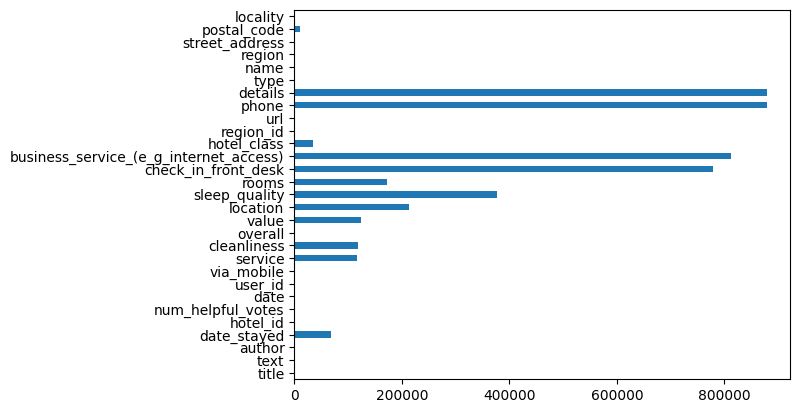

In [10]:
df_null = df.isnull()
print(df_null.sum())
df_null.sum().plot.barh()

In [ ]:
print(df_null.mean() * 100)

title                                       0.000000
text                                        0.000000
author                                      0.000000
date_stayed                                 7.693717
hotel_id                                    0.000000
num_helpful_votes                           0.000000
date                                        0.000000
user_id                                     0.000000
via_mobile                                  0.000000
service                                    13.390419
cleanliness                                13.513689
overall                                     0.000000
value                                      14.212559
location                                   24.318972
sleep_quality                              42.985974
rooms                                      19.709161
check_in_front_desk                        88.642337
business_service_(e_g_internet_access)     92.518562
hotel_class                                 3.

In [11]:
df = df.drop(['sleep_quality','check_in_front_desk','business_service_(e_g_internet_access)','phone', 'details'], axis=1) # remove if NA is more than 30%

In [12]:
nunique = df.nunique() # len(unique()) 와 동일함
print(nunique)

title                631300
text                 877573
author               577942
date_stayed             168
hotel_id               3945
num_helpful_votes       100
date                   3948
user_id              878561
via_mobile                2
service                   5
cleanliness               5
overall                   6
value                     5
location                  5
rooms                     5
hotel_class               9
region_id                25
url                    3945
type                      1
name                   3876
region                   17
street_address         3927
postal_code             851
locality                 25
dtype: int64


In [ ]:
for col in nunique.index: # 범주형 변수에 어떤 값이 있는지 확인
    print(pd.Series(df[col].unique()).head(2))

0    “Truly is "Jewel of the Upper Wets Side"”
1                    “My home away from home!”
dtype: object
0    Stayed in a king suite for 11 nights and yes i...
1    On every visit to NYC, the Hotel Beacon is the...
dtype: object
0    {'username': 'Papa_Panda', 'num_cities': 22, '...
1    {'username': 'Maureen V', 'num_reviews': 2, 'n...
dtype: object
0    December 2012
1      August 2012
dtype: object
0      93338
1    1762573
dtype: int64
0    0
1    1
dtype: int64
0    2012-12-17
1    2012-12-18
dtype: object
0    147643103
1    147639004
dtype: int64
0    False
1     True
dtype: bool
0    5.0
1    4.0
dtype: float64
0    5.0
1    4.0
dtype: float64
0    5.0
1    4.0
dtype: float64
0    5.0
1    4.0
dtype: float64
0    5.0
1    4.0
dtype: float64
0    5.0
1    4.0
dtype: float64
0    3.0
1    4.0
dtype: float64
0    60763
1    56003
dtype: int64
0    http://www.tripadvisor.com/Hotel_Review-g60763...
1    http://www.tripadvisor.com/Hotel_Review-g60763...
dtype: object
0    hotel
dt

In [ ]:
df[df['hotel_class'].isna()].shape

(34937, 16)

In [ ]:
# 동일한 호텔인데 hotel_class 없는 것도 있을지?
offr['id'].is_unique
# True -> 중복 없음

True

### **2. 시각화**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878561 entries, 0 to 878560
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   title              878561 non-null  object 
 1   text               878561 non-null  object 
 2   author             878561 non-null  object 
 3   date_stayed        810967 non-null  object 
 4   hotel_id           878561 non-null  int64  
 5   num_helpful_votes  878561 non-null  int64  
 6   date               878561 non-null  object 
 7   user_id            878561 non-null  int64  
 8   via_mobile         878561 non-null  bool   
 9   service            760918 non-null  float64
 10  cleanliness        759835 non-null  float64
 11  overall            878561 non-null  float64
 12  value              753695 non-null  float64
 13  location           664904 non-null  float64
 14  rooms              705404 non-null  float64
 15  hotel_class        843624 non-null  float64
 16  re

In [ ]:
df.describe()

,hotel_id,num_helpful_votes,user_id,service,cleanliness,overall,value,location,rooms,hotel_class,region_id
count,8.785610e+05,878561.000000,8.785610e+05,760918.000000,759835.000000,878561.000000,753695.000000,664904.000000,705404.000000,843624.000000,878561.000000
mean,3.058972e+05,1.153104,8.633481e+07,4.069742,4.208512,3.936228,3.896310,4.415007,3.921873,3.465306,52742.420843
std,4.388314e+05,2.898120,4.999254e+07,1.179085,1.075466,1.165074,1.179857,0.889482,1.149181,0.743663,12264.535506
min,7.257200e+04,0.000000,2.243990e+05,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,28970.000000
25%,8.999800e+04,0.000000,3.488850e+07,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,3.000000,35805.000000
50%,1.114080e+05,0.000000,1.113905e+08,4.000000,5.000000,4.000000,4.000000,5.000000,4.000000,3.500000,60745.000000
75%,2.416400e+05,1.000000,1.283089e+08,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,60763.000000
max,3.574675e+06,515.000000,1.478017e+08,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,60956.000000


#### 2.1 지역별

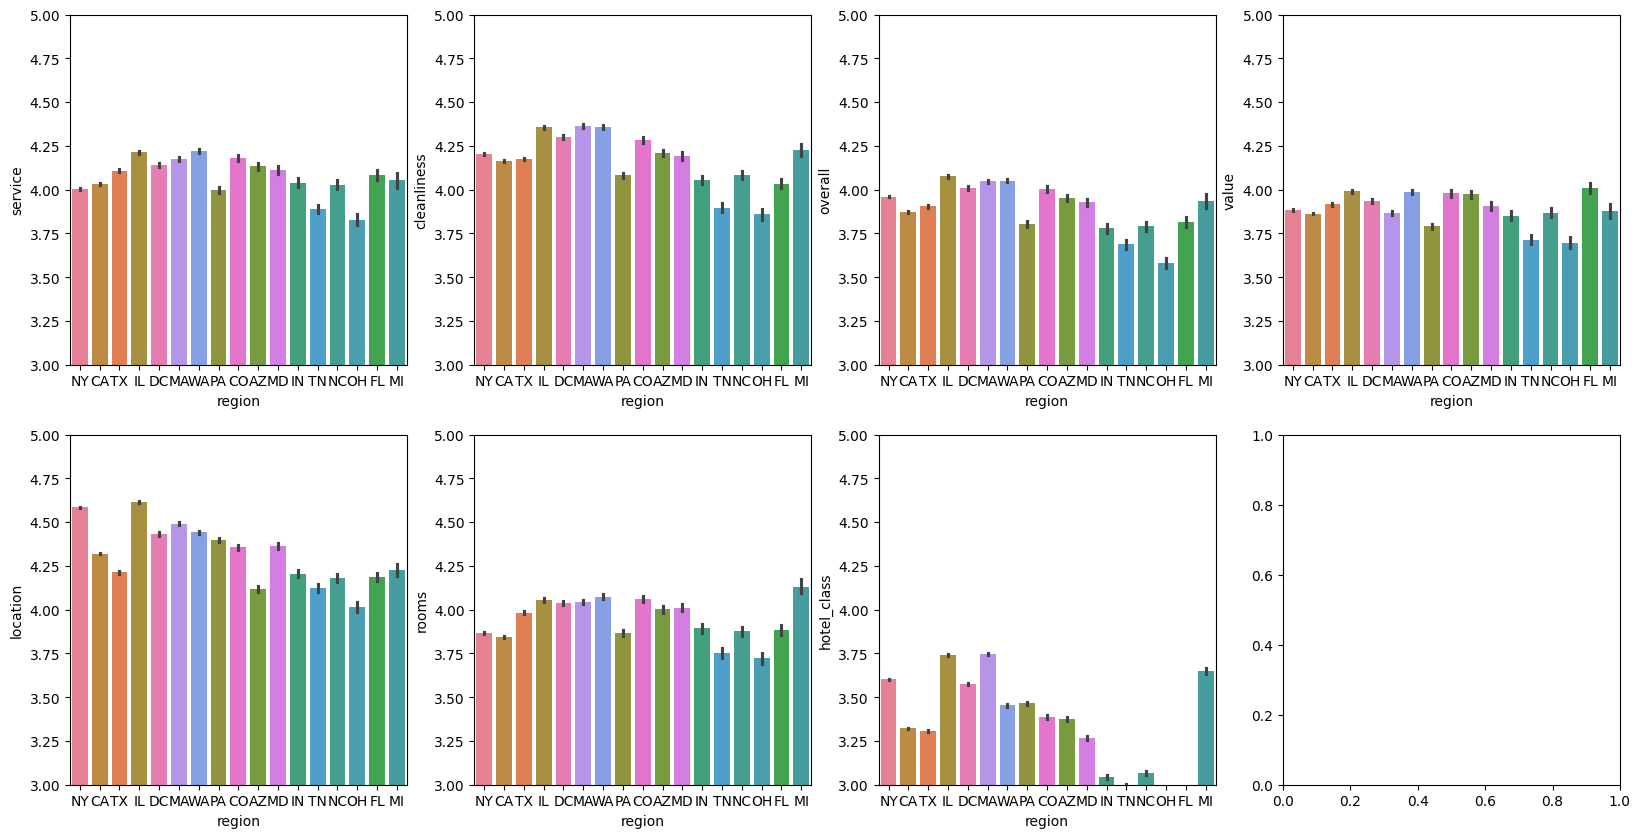

In [13]:
num_cols = df._get_numeric_data().columns[4:11].tolist() # int이지만 범주형 자료임
ordering = df['region'].value_counts().index

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
for i, num_cols in enumerate(num_cols):
  rows = i // 4
  cols = i % 4
  sns.barplot(df, x='region', y=num_cols, hue='region', order = ordering, ax=axes[rows][cols]).set(ylim=(3,5))

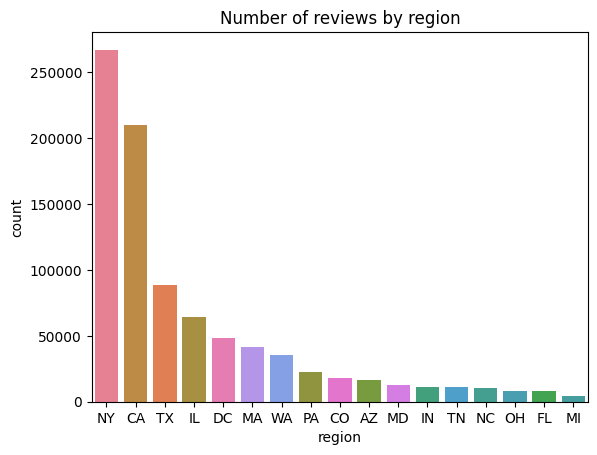

In [ ]:
sns.countplot(data=df, x='region', hue='region', order = ordering).set(title='Number of reviews by region')
plt.show()
# 리뷰 건수는 지역별로 차이가 큼

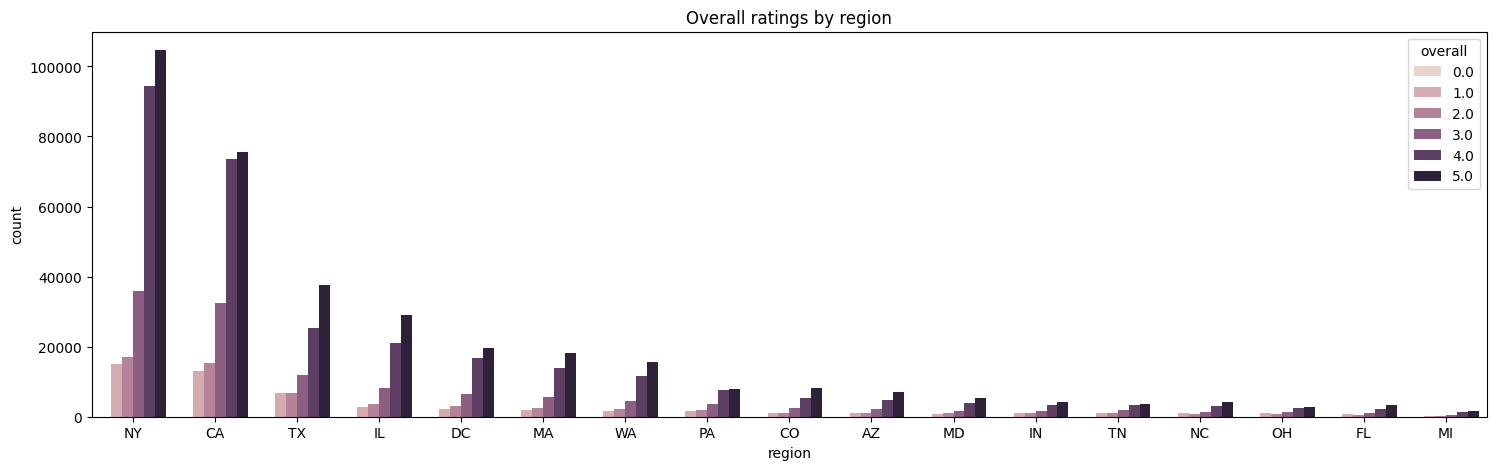

In [14]:
df_size = df.groupby(['region','overall']).size().reset_index()
df_size.columns = ['region','overall','count']

plt.figure(figsize=(18,5))
sns.barplot(data=df_size, x='region', y='count', hue='overall', order =ordering).set(title='Overall ratings by region')
plt.show()
# 모든 지역에서 5>4>3>2>1 순으로 리뷰 수가 많음

In [15]:
# Overall review 좋고 나쁨에 따라 review_high 변수 설정
df['review_high'] = df['overall'] >= 4
df[['overall','review_high']].tail()

,overall,review_high
878556,4.0,True
878557,4.0,True
878558,5.0,True
878559,5.0,True
878560,4.0,True


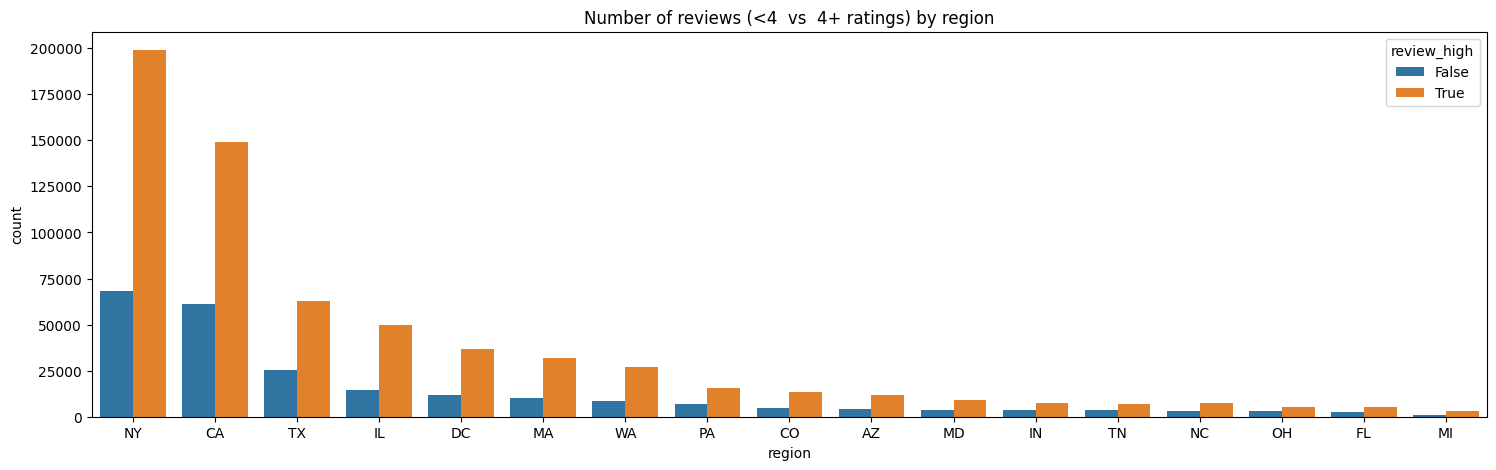

In [ ]:
plt.figure(figsize=(18,5))
sns.countplot(data=df, x="region", hue="review_high", order = df['region'].value_counts().index).set(title='Number of reviews (<4  vs  4+ ratings) by region')
plt.show()
# 전반적으로 평점 4점 이상임

In [16]:
cross_tab_prob = pd.crosstab(index=df['region'], columns=df['review_high'], normalize='index')
cross_tab = pd.crosstab(index=df['region'], columns=df['review_high'])

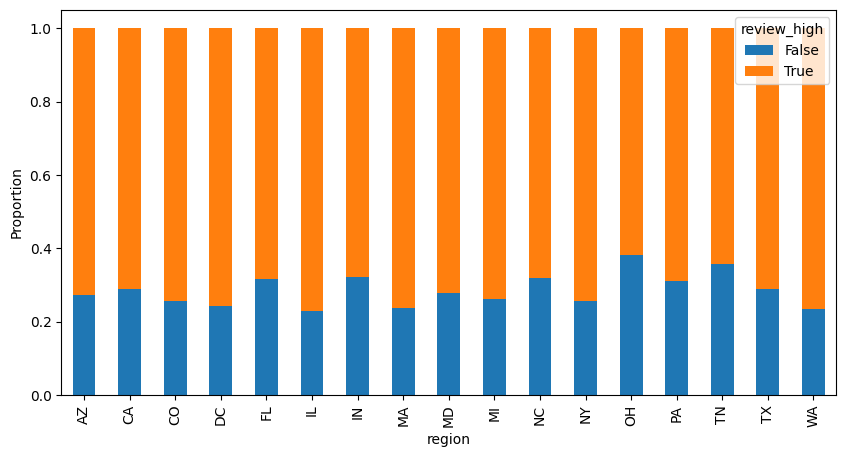

In [ ]:
cross_tab_prob.plot(kind="bar", stacked=True, figsize=(10,5))
plt.ylabel('Proportion')
plt.show()
# 평점 4점 이상 비율은 전반적으로 비슷함

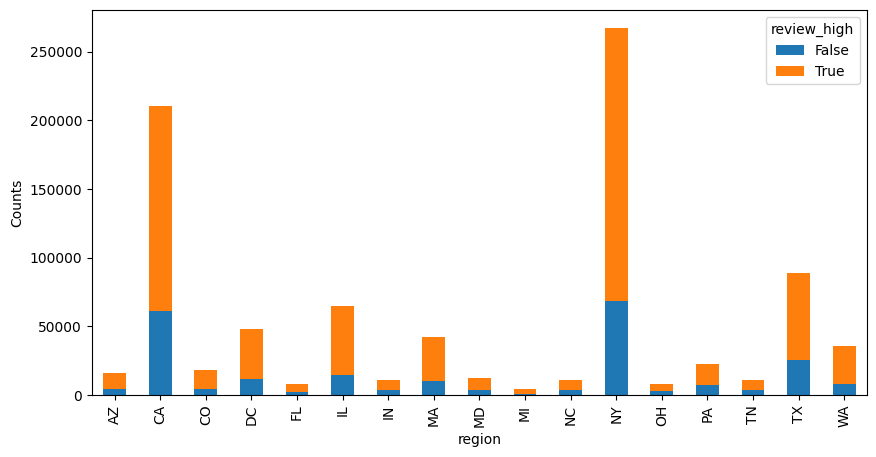

In [ ]:
cross_tab.plot(kind="bar", stacked=True, figsize=(10,5))
plt.ylabel('Counts')
plt.show()
# NY, CA 리뷰 수가 가장 많은 만큼 높게 나타남

#### 2.2 호텔 등급별

In [ ]:
df['hotel_class'].value_counts(dropna=False)

4.0    288492
3.0    173205
3.5    167315
2.5     69926
2.0     62547
4.5     46595
NaN     34937
5.0     29192
1.5      4662
1.0      1690
Name: hotel_class, dtype: int64

In [17]:
num_cols = df._get_numeric_data().columns[4:11].tolist() # ratings 자료만 보기
df.groupby(['hotel_class'])[num_cols].mean()

,service,cleanliness,overall,value,location,rooms,hotel_class
hotel_class,,,,,,,
1.0,2.638032,2.593496,2.398817,2.838261,3.716304,2.266722,1.0
1.5,2.281522,2.120437,2.185972,2.661748,3.728132,2.017501,1.5
2.0,3.631676,3.624538,3.407757,3.708962,4.031935,3.310166,2.0
2.5,3.896676,3.967140,3.682178,3.891334,4.169018,3.693025,2.5
3.0,4.062780,4.177366,3.920666,3.995408,4.361514,3.876220,3.0
3.5,4.093818,4.223052,3.953369,3.909872,4.397011,3.946169,3.5
4.0,4.164514,4.362430,4.071853,3.875089,4.563501,4.069730,4.0
4.5,4.340841,4.547133,4.288357,3.949144,4.642359,4.307189,4.5
5.0,4.509657,4.691122,4.452624,4.050352,4.646314,4.510430,5.0


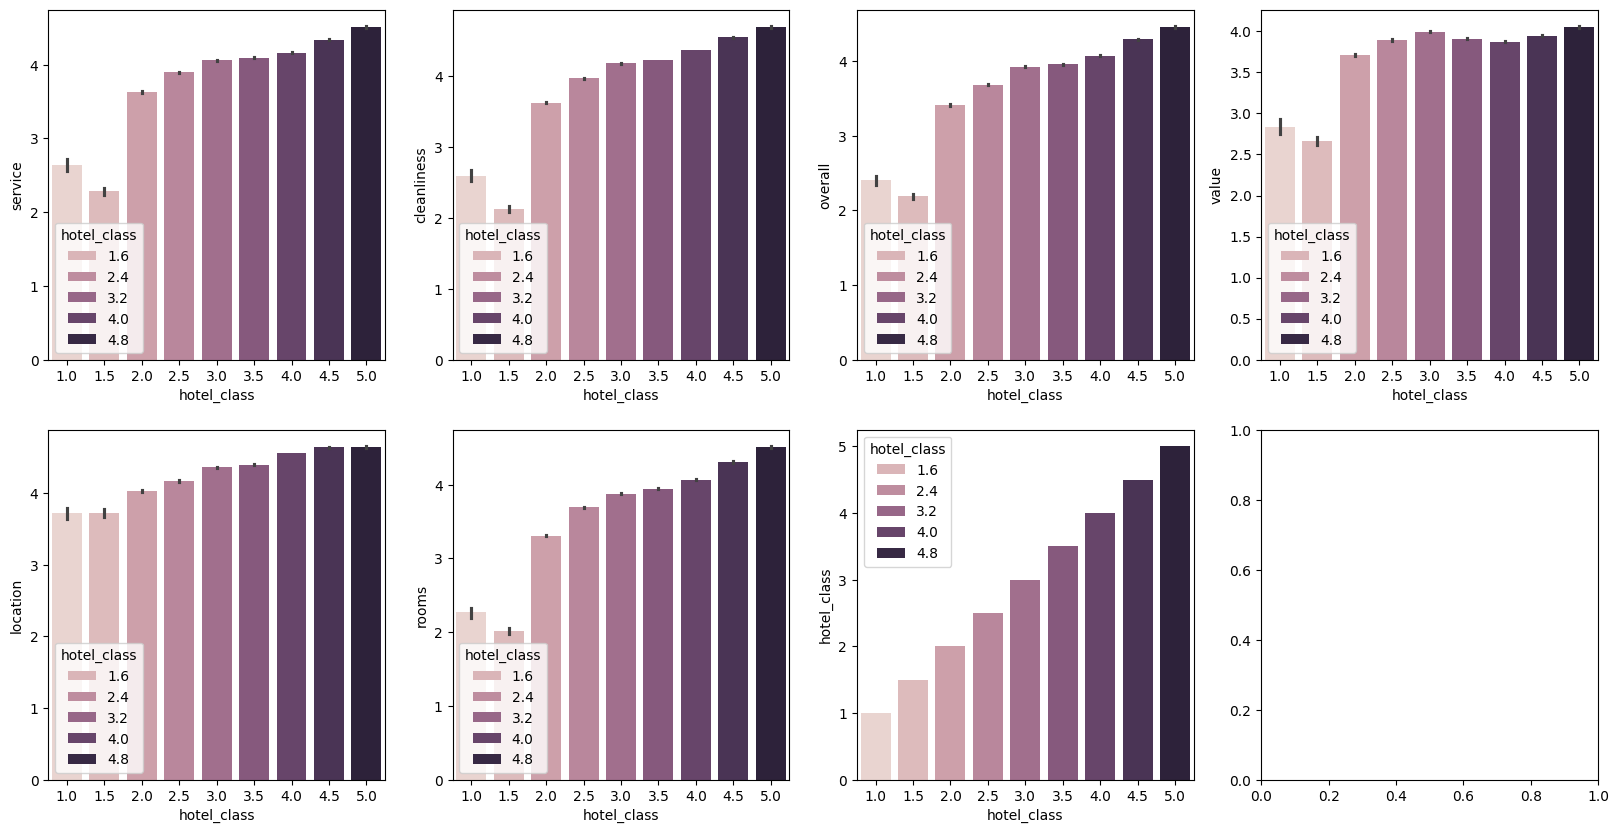

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
for i, num_cols in enumerate(num_cols):
  rows = i // 4
  cols = i % 4
  sns.barplot(df, x='hotel_class', y=num_cols, hue='hotel_class', ax=axes[rows][cols])
# 전반적으로 호텔 등급이 높을수록 평점도 높아짐

In [26]:
# hotel_class 에 따른 overall ratings 관계를 파악하기
# 변수들이 범주형 -> 카이제곱; 연속형 -> 상관계수
# ANOVA는 연속형 종속변수 + 범주형 독립변수
# 1-5점 척도의 범주형 변수이기 때문에, 카이제곱검정 실시
# HO: 두 변수가 서로 독립이다
# H1: 두 변수는 연관이 있다

from scipy.stats import chi2_contingency

num_cols = df._get_numeric_data().columns[4:11].tolist() # ratings 자료만 보기

for var in num_cols:
  if var !='hotel_class':
      # 관측도수 테이블 생성
      tab = pd.crosstab(df[var], df['hotel_class'])

      # 카이제곱 검정
      chi2, p, _, _ = chi2_contingency(tab)

      # Cramer's V: 두 변수의 연관성 크기 측정
      n = np.sum(tab)
      min_dim = min(tab.shape) - 1
      v = np.sqrt((chi2/n) / min_dim)
      # from scipy.stats.contingency import association
      # association(rows, method="cramer")

      # 결과 출력
      print(f"\n{var} & hotel_class:")
      print(f"Chi square value: {chi2}")
      print(f"p-value: {p}")
      print(f"Cramer's V: {v}")

# cleanliness 와 hotel_class 가장 연관성 높음


service & hotel_class:
Chi square value: 32578.876958913792
p-value: 0.0
Cramer's V: hotel_class
1.0    2.606324
1.5    1.538270
2.0    0.395566
2.5    0.369225
3.0    0.234404
3.5    0.235970
4.0    0.179730
4.5    0.444615
5.0    0.555934
dtype: float64

cleanliness & hotel_class:
Chi square value: 61633.30039451964
p-value: 0.0
Cramer's V: hotel_class
1.0    3.539363
1.5    2.104508
2.0    0.542007
2.5    0.507352
3.0    0.322515
3.5    0.324942
4.0    0.247640
4.5    0.613507
5.0    0.768524
dtype: float64

overall & hotel_class:
Chi square value: 56376.624767670284
p-value: 0.0
Cramer's V: hotel_class
1.0    2.582981
1.5    1.555172
2.0    0.424582
2.5    0.401555
3.0    0.255143
3.5    0.259595
4.0    0.197696
4.5    0.491920
5.0    0.621488
dtype: float64

value & hotel_class:
Chi square value: 16480.09035083416
p-value: 0.0
Cramer's V: hotel_class
1.0    1.892783
1.5    1.091850
2.0    0.282575
2.5    0.263584
3.0    0.167538
3.5    0.168600
4.0    0.128504
4.5    0.318306
5.0

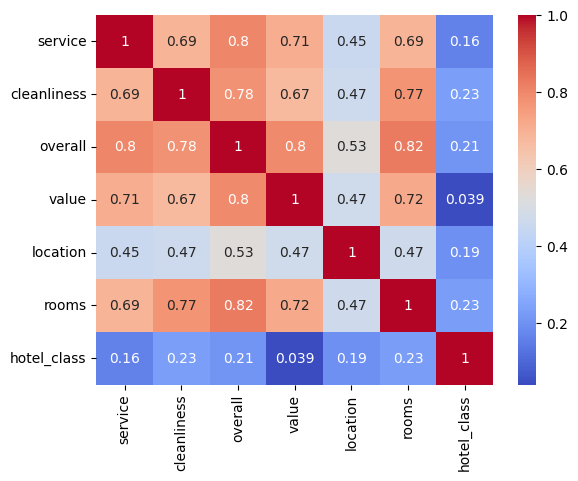

In [ ]:
# 만약 heatmap으로 상관계수를 구했다면,
df_matrix = df[num_cols]
df_corr = df_matrix.corr()
sns.heatmap(data=df_corr, annot=True, cmap="coolwarm")
plt.show()
# hotel_class 는 cleanliness, rooms, overall 과 약한 양적 선형관계 있음
# overall 평점은 service, cleanliness, value, rooms 와 강한 양적 선형관계
# location, hotel_class 과는 약한 양적 선형관계 있는 것으로 나타남
# 그 외에도 cleanliness 와 rooms 강한 양적 선형관계

####**2.3 평점별**

In [ ]:
df['overall'].value_counts(dropna=False)

5.0    348319
4.0    293727
3.0    122565
2.0     60085
1.0     53848
0.0        17
Name: overall, dtype: int64

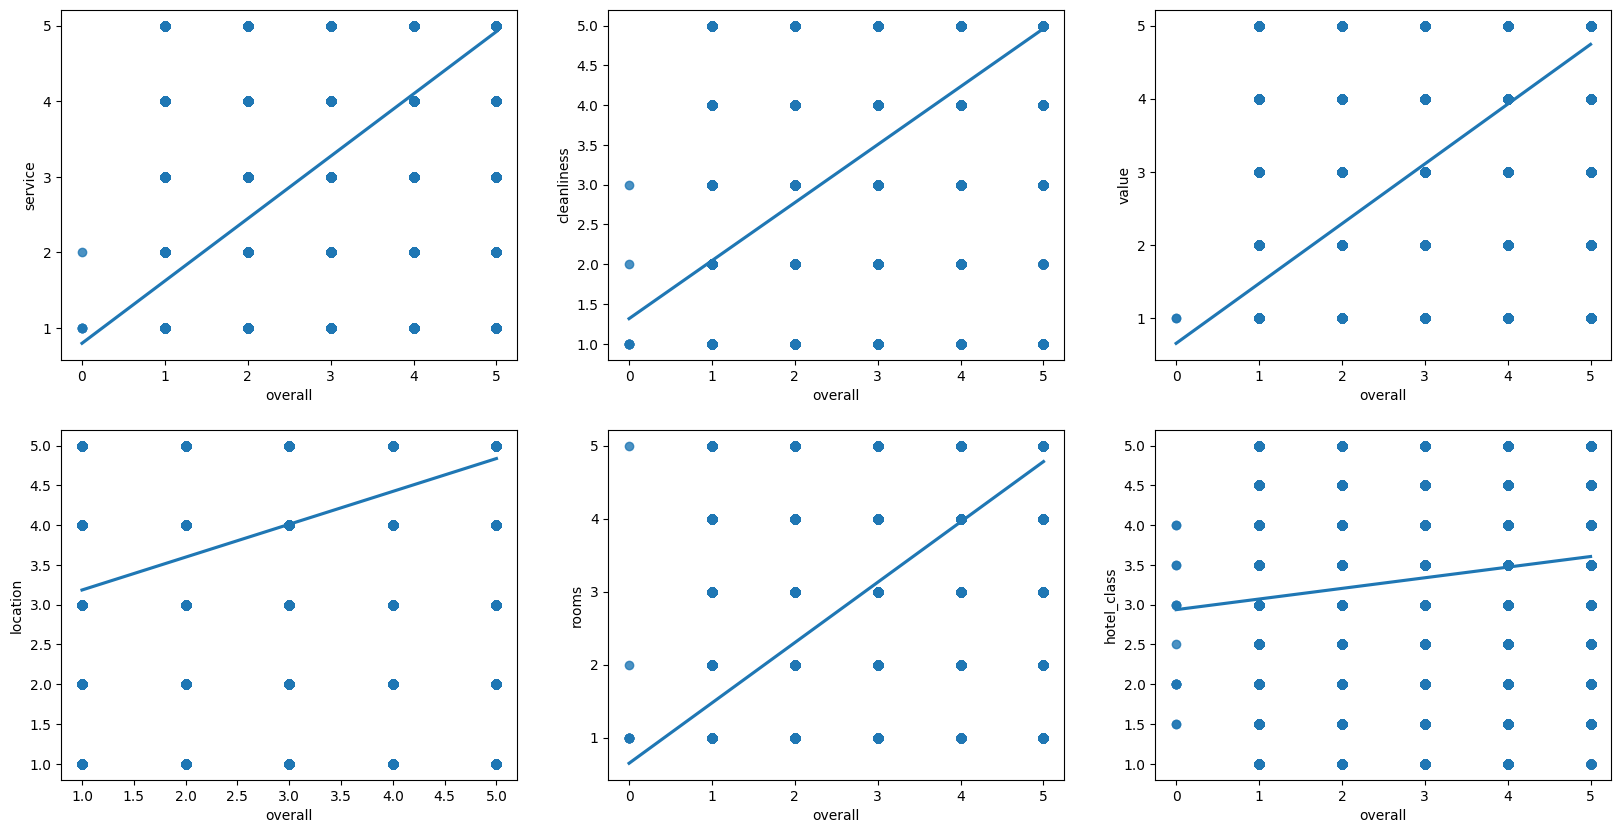

In [ ]:
# overall 평점은 service, cleanliness, value, rooms 와 강한 양적 선형관계
# location, hotel_class 과는 약한 양적 선형관계 있는 것으로 나타남

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
col =  df_matrix.loc[:,df_matrix.columns != 'overall'].columns.tolist()
for i, col in enumerate(col):
  rows = i // 3
  cols = i % 3
  sns.regplot(data=df_matrix, x="overall", y=col, ax=axes[rows][cols])